# Scraping the justETF [Screener](https://www.justetf.com/en/find-etf.html)

## Content

- [Request the data](#request)
- [Clean up the data](#cleanup)
- [Enrich the data](#enrich)
- [Save the data](#save)
- [Visualize some statistics](#visualize)
- [Search over the data](#search)

In [1]:
%load_ext nb_black
%load_ext autoreload

<IPython.core.display.Javascript object>

In [2]:
%autoreload 1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%aimport utils

<IPython.core.display.Javascript object>

In [3]:
pd.set_option("display.max_columns", None)

<IPython.core.display.Javascript object>

<a id="request"></a>
## Request the data

In [4]:
last_four_years = [
    str((pd.Timestamp("now") - pd.DateOffset(years=i)).year) for i in range(1, 5)
]

<IPython.core.display.Javascript object>

In [5]:
DETAILS_KEY_MAPPING = {
    # IDs
    "isin": "isin",
    "wkn": "wkn",
    "ticker": "ticker",
    "valorNumber": "valor",
    # Basic info
    "name": "name",
    "groupValue": "index",
    "inceptionDate": "date",
    "strategy": "strategy",  # Custom field added during request
    "domicileCountry": "domicile_country",
    "fundCurrency": "currency",
    "hasSecuritiesLending": "securities_lending",
    "distributionPolicy": "dividends",
    "ter": "ter",
    "replicationMethod": "replication",
    "fundSize": "size",
    # Value return
    "ytdReturnCUR": "yesterday",
    "weekReturnCUR": "last_week",
    "monthReturnCUR": "last_month",
    "threeMonthReturnCUR": "last_three_months",
    "sixMonthReturnCUR": "last_six_months",
    "yearReturnCUR": "last_year",
    "threeYearReturnCUR": "last_three_years",
    "fiveYearReturnCUR": "last_five_years",
    "yearReturn1CUR": last_four_years[0],
    "yearReturn2CUR": last_four_years[1],
    "yearReturn3CUR": last_four_years[2],
    "yearReturn4CUR": last_four_years[3],
    # Dividends
    "currentDividendYield": "last_dividends",
    "yearDividendYield": "last_year_dividends",
    # Volatility
    "yearVolatilityCUR": "last_year_volatility",
    "threeYearVolatilityCUR": "last_three_years_volatility",
    "fiveYearVolatilityCUR": "last_five_years_volatility",
    # Return/Risk
    "yearReturnPerRiskCUR": "last_year_return_per_risk",
    "threeYearReturnPerRiskCUR": "last_three_years_return_per_risk",
    "fiveYearReturnPerRiskCUR": "last_five_years_return_per_risk",
    # Ignored fields
    # "groupParam": query for index search, indices are already received
    # "selected": not interesting
    # "clazz": some value, the most are empty strings, some are "highl_c"
    # "savingsPlanReady": "Savings plan ready from x.xx EUR" text
}

<IPython.core.display.Javascript object>

In [6]:
INT64_COLUMNS = ["valor", "size"]
CATEGORY_COLUMNS = ["strategy", "domicile_country", "dividends", "replication"]
FLOAT_COLUMNS = [
    "ter",
    "yesterday",
    "last_week",
    "last_month",
    "last_three_months",
    "last_six_months",
    "last_year",
    "last_three_years",
    "last_five_years",
    "last_dividends",
    "last_year_dividends",
    "last_year_volatility",
    "last_three_years_volatility",
    "last_five_years_volatility",
    "last_year_return_per_risk",
    "last_three_years_return_per_risk",
    "last_five_years_return_per_risk",
] + last_four_years

<IPython.core.display.Javascript object>

In [7]:
data = {key: [] for key in DETAILS_KEY_MAPPING}
for sample in utils.make_request():
    for key, values in data.items():
        values.append(sample[key])

<IPython.core.display.Javascript object>

In [8]:
etf_df = pd.DataFrame(data).rename(columns=DETAILS_KEY_MAPPING)

<IPython.core.display.Javascript object>

In [9]:
etf_df.shape

(2672, 35)

<IPython.core.display.Javascript object>

In [10]:
etf_df.head(3)

,isin,wkn,ticker,valor,name,index,date,strategy,domicile_country,currency,securities_lending,dividends,ter,replication,size,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2021,2020,2019,2018,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
0,CH0496484640,A22FMC,21XA,49648464,21Shares Bitcoin Suisse Index ETP,21Shares Bitcoin Suisse,04.10.19,Long-only,Switzerland,USD,No,Accumulating,2.50%,Physically<br />backed,28,-38.90%,-5.35%,-28.91%,-22.74%,-46.65%,-19.87%,-,-,129.88%,252.92%,-,-,-,-,72.61%,-,-,-0.27,-,-
1,CH0445689208,A2TT3D,21XH,44568920,21Shares Crypto Basket Index ETP,21Shares Crypto Basket,21.11.18,Long-only,Switzerland,USD,No,Accumulating,2.50%,Physically<br />backed,111,-50.78%,-6.49%,-37.14%,-32.25%,-57.58%,-33.83%,200.00%,-,166.39%,241.24%,20.41%,-,-,-,77.35%,78.21%,-,-0.44,0.56,-
2,IE00B0M62Y33,A0HGWF,IUSJ,2308837,iShares AEX UCITS ETF,AEX®,18.11.05,Long-only,Ireland,EUR,Yes,Distributing,0.30%,Full replication,471,-11.57%,2.73%,1.06%,-3.27%,-9.75%,-0.02%,34.98%,47.69%,29.89%,5.14%,27.55%,-8.05%,1.81%,1.78%,18.43%,20.69%,17.65%,0.00,0.51,0.46


<IPython.core.display.Javascript object>

In [11]:
len(etf_df["isin"].unique())

2672

<IPython.core.display.Javascript object>

<a id="cleanup"></a>
## Clean up the data

In [12]:
for column in etf_df:
    etf_df[column] = (
        etf_df[column]
        .str.replace("<br />", " ")
        .str.replace(",", "")
        .replace("-", pd.NA)
    )

<IPython.core.display.Javascript object>

In [13]:
for column in INT64_COLUMNS:
    etf_df[column] = etf_df[column].astype("Int64")

<IPython.core.display.Javascript object>

In [14]:
for column in CATEGORY_COLUMNS:
    etf_df[column] = etf_df[column].astype("category")

<IPython.core.display.Javascript object>

In [15]:
for column in FLOAT_COLUMNS:
    etf_df[column] = (
        etf_df[column].str.removesuffix("%").replace(pd.NA, "nan").astype("float64")
    )

<IPython.core.display.Javascript object>

In [16]:
etf_df["date"] = pd.to_datetime(etf_df["date"], format="%d.%m.%y")

<IPython.core.display.Javascript object>

Keep insertion date, but also calculate age in years to simplify search over dataset.

In [17]:
columns = etf_df.columns.tolist()
etf_df["age"] = (
    pd.Timestamp("now") - pd.to_datetime(etf_df["date"], format="%d.%m.%y")
) / pd.to_timedelta(365, unit="D")
columns.insert(columns.index("date") + 1, "age")
etf_df = etf_df[columns]

<IPython.core.display.Javascript object>

In [18]:
etf_df["securities_lending"] = (
    etf_df["securities_lending"].replace({"Yes": True, "No": False}).astype("bool")
)

<IPython.core.display.Javascript object>

Separate hedged flag from currency.

In [19]:
columns = etf_df.columns.tolist()
columns.insert(columns.index("currency") + 1, "hedged")
etf_df["hedged"] = etf_df["currency"].str.endswith("Hedged")
etf_df["currency"] = etf_df["currency"].str.removesuffix(" Hedged").astype("category")
etf_df = etf_df[columns]

<IPython.core.display.Javascript object>

In [20]:
etf_df.head(3)

,isin,wkn,ticker,valor,name,index,date,age,strategy,domicile_country,currency,hedged,securities_lending,dividends,ter,replication,size,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2021,2020,2019,2018,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
0,CH0496484640,A22FMC,21XA,49648464,21Shares Bitcoin Suisse Index ETP,21Shares Bitcoin Suisse,2019-10-04,2.647697,Long-only,Switzerland,USD,False,False,Accumulating,2.5,Physically backed,28,-38.90,-5.35,-28.91,-22.74,-46.65,-19.87,NaN,NaN,129.88,252.92,NaN,NaN,NaN,NaN,72.61,NaN,NaN,-0.27,NaN,NaN
1,CH0445689208,A2TT3D,21XH,44568920,21Shares Crypto Basket Index ETP,21Shares Crypto Basket,2018-11-21,3.516190,Long-only,Switzerland,USD,False,False,Accumulating,2.5,Physically backed,111,-50.78,-6.49,-37.14,-32.25,-57.58,-33.83,200.00,NaN,166.39,241.24,20.41,NaN,NaN,NaN,77.35,78.21,NaN,-0.44,0.56,NaN
2,IE00B0M62Y33,A0HGWF,IUSJ,2308837,iShares AEX UCITS ETF,AEX®,2005-11-18,16.532629,Long-only,Ireland,EUR,False,True,Distributing,0.3,Full replication,471,-11.57,2.73,1.06,-3.27,-9.75,-0.02,34.98,47.69,29.89,5.14,27.55,-8.05,1.81,1.78,18.43,20.69,17.65,0.00,0.51,0.46


<IPython.core.display.Javascript object>

<a id="enrich"></a>
## Enrich the data

In [21]:
columns = etf_df.columns.tolist()

<IPython.core.display.Javascript object>

In [22]:
etf_df["asset"] = pd.NA
for asset, name in utils.ASSETS.items():
    isins = {sample["isin"] for sample in utils.make_request(asset=asset)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, "asset"] = name
etf_df["asset"] = etf_df["asset"].astype("category")

<IPython.core.display.Javascript object>

In [23]:
etf_df["instrument"] = pd.NA
for instrument, name in utils.INSTRUMENTS.items():
    isins = {sample["isin"] for sample in utils.make_request(instrument=instrument)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, "instrument"] = name
etf_df["instrument"] = etf_df["instrument"].astype("category")

<IPython.core.display.Javascript object>

In [24]:
etf_df["region"] = pd.NA
for region, name in utils.REGIONS.items():
    isins = {sample["isin"] for sample in utils.make_request(region=region)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, "region"] = name
etf_df["region"] = etf_df["region"].astype("category")

<IPython.core.display.Javascript object>

In [25]:
new_columns = ["asset", "instrument", "region"]
for exchange, name in utils.EXCHANGES.items():
    name = f"at_{name}"
    etf_df[name] = False
    new_columns.append(name)
    isins = {sample["isin"] for sample in utils.make_request(exchange=exchange)}
    mask = etf_df["isin"].isin(isins)
    etf_df.loc[mask, name] = True

<IPython.core.display.Javascript object>

In [26]:
etf_df = etf_df[
    columns[: columns.index("size") + 1]
    + new_columns
    + columns[columns.index("size") + 1 :]
]

<IPython.core.display.Javascript object>

In [27]:
etf_df.shape

(2672, 46)

<IPython.core.display.Javascript object>

In [28]:
etf_df.head(3)

,isin,wkn,ticker,valor,name,index,date,age,strategy,domicile_country,currency,hedged,securities_lending,dividends,ter,replication,size,asset,instrument,region,at_gettex,at_xetra,at_london,at_euronext,at_stuttgart,at_six,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2021,2020,2019,2018,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
0,CH0496484640,A22FMC,21XA,49648464,21Shares Bitcoin Suisse Index ETP,21Shares Bitcoin Suisse,2019-10-04,2.647697,Long-only,Switzerland,USD,False,False,Accumulating,2.5,Physically backed,28,Cryptocurrencies,ETN,NaN,True,False,False,False,True,True,-38.90,-5.35,-28.91,-22.74,-46.65,-19.87,NaN,NaN,129.88,252.92,NaN,NaN,NaN,NaN,72.61,NaN,NaN,-0.27,NaN,NaN
1,CH0445689208,A2TT3D,21XH,44568920,21Shares Crypto Basket Index ETP,21Shares Crypto Basket,2018-11-21,3.516190,Long-only,Switzerland,USD,False,False,Accumulating,2.5,Physically backed,111,Cryptocurrencies,ETN,NaN,True,True,False,True,False,True,-50.78,-6.49,-37.14,-32.25,-57.58,-33.83,200.00,NaN,166.39,241.24,20.41,NaN,NaN,NaN,77.35,78.21,NaN,-0.44,0.56,NaN
2,IE00B0M62Y33,A0HGWF,IUSJ,2308837,iShares AEX UCITS ETF,AEX®,2005-11-18,16.532629,Long-only,Ireland,EUR,False,True,Distributing,0.3,Full replication,471,Equity,ETF,NaN,True,False,True,False,False,True,-11.57,2.73,1.06,-3.27,-9.75,-0.02,34.98,47.69,29.89,5.14,27.55,-8.05,1.81,1.78,18.43,20.69,17.65,0.00,0.51,0.46


<IPython.core.display.Javascript object>

<a id="save"></a>
## Save the data

In [29]:
etf_df.to_csv("justetf.csv", index=False)

<IPython.core.display.Javascript object>

<a id="visualize"></a>
## Visualize some statistics

<AxesSubplot:xlabel='Count', ylabel='strategy'>

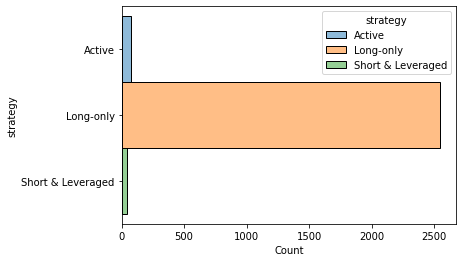

<IPython.core.display.Javascript object>

In [30]:
sns.histplot(etf_df, y="strategy", hue="strategy", discrete=True)

<AxesSubplot:xlabel='Count', ylabel='instrument'>

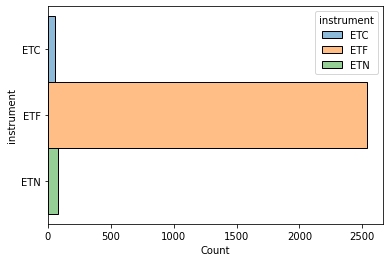

<IPython.core.display.Javascript object>

In [31]:
sns.histplot(etf_df, y="instrument", hue="instrument", discrete=True)

<AxesSubplot:xlabel='Count', ylabel='asset'>

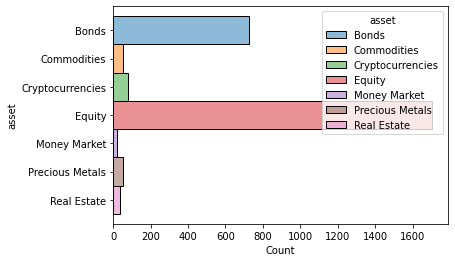

<IPython.core.display.Javascript object>

In [32]:
sns.histplot(etf_df, y="asset", hue="asset", discrete=True)

<AxesSubplot:xlabel='Count', ylabel='region'>

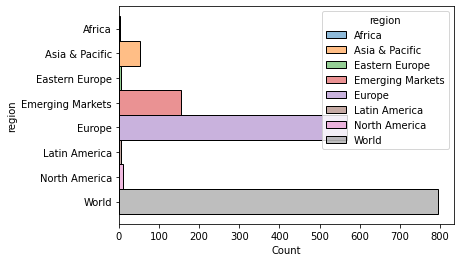

<IPython.core.display.Javascript object>

In [33]:
sns.histplot(etf_df, y="region", hue="region", discrete=True)

<AxesSubplot:xlabel='Count', ylabel='currency'>

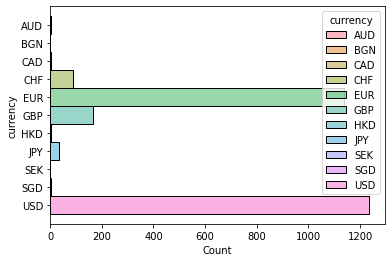

<IPython.core.display.Javascript object>

In [34]:
sns.histplot(etf_df, y="currency", hue="currency", discrete=True)

<AxesSubplot:xlabel='age', ylabel='size'>

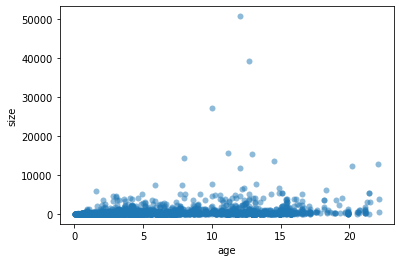

<IPython.core.display.Javascript object>

In [35]:
sns.scatterplot(data=etf_df, x="age", y="size", alpha=0.5, linewidth=0)

The most frequent indices.

In [36]:
index_counts = etf_df["index"].value_counts()

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Count', ylabel='index'>

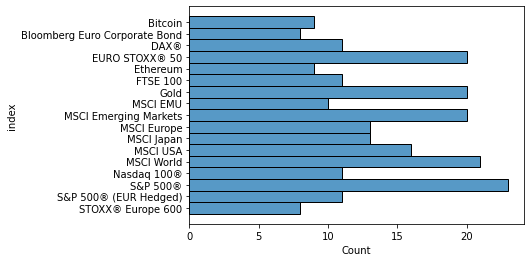

<IPython.core.display.Javascript object>

In [37]:
sns.histplot(
    etf_df[etf_df["index"].isin(index_counts[index_counts > 7].index)],
    y="index",
    discrete=True,
)

<a id="search"></a>
## Search over the data

Compare accumulating MSCI World ETFs older than 2 years with fond size greater than € 50M.

In [38]:
acc_msci_world_df = etf_df[
    (etf_df["index"] == "MSCI World")
    & (etf_df["dividends"] == "Accumulating")
    & (etf_df["age"] > 2)
    & (etf_df["size"] > 50)
]

<IPython.core.display.Javascript object>

In [39]:
acc_msci_world_df.shape

(8, 46)

<IPython.core.display.Javascript object>

In [40]:
acc_msci_world_df

,isin,wkn,ticker,valor,name,index,date,age,strategy,domicile_country,currency,hedged,securities_lending,dividends,ter,replication,size,asset,instrument,region,at_gettex,at_xetra,at_london,at_euronext,at_stuttgart,at_six,yesterday,last_week,last_month,last_three_months,last_six_months,last_year,last_three_years,last_five_years,2021,2020,2019,2018,last_dividends,last_year_dividends,last_year_volatility,last_three_years_volatility,last_five_years_volatility,last_year_return_per_risk,last_three_years_return_per_risk,last_five_years_return_per_risk
1597,LU1437016972,A2ATYV,XPAN,34333476,Amundi ETF MSCI World UCITS ETF DR,MSCI World,2016-11-17,5.527149,Long-only,Luxembourg,EUR,False,True,Accumulating,0.18,Full replication,498,Equity,ETF,World,True,False,True,True,False,False,-9.55,1.94,-2.28,-2.88,-6.90,7.02,43.47,62.80,31.51,6.34,30.97,-4.99,NaN,NaN,15.72,20.00,17.02,0.45,0.64,0.60
1600,LU1681043599,A2H59Q,AMEW,38784696,Amundi MSCI World UCITS ETF EUR (C),MSCI World,2018-04-18,4.110711,Long-only,Luxembourg,EUR,False,False,Accumulating,0.38,Swap based Unfunded,2029,Equity,ETF,World,True,True,False,True,True,True,-9.32,2.22,-2.82,-2.91,-6.82,6.72,43.04,62.24,30.94,6.26,29.84,-4.19,NaN,NaN,14.87,19.65,16.80,0.45,0.64,0.60
1603,IE00B60SX394,A0RGCS,SC0J,10128224,Invesco MSCI World UCITS ETF,MSCI World,2009-04-02,13.160026,Long-only,Ireland,USD,False,False,Accumulating,0.19,Swap based Unfunded,2938,Equity,ETF,World,True,True,True,False,True,True,-9.61,1.60,-2.59,-3.12,-6.92,7.02,43.80,64.14,32.10,6.28,30.38,-4.29,NaN,NaN,15.43,20.20,17.19,0.45,0.64,0.61
1604,IE00B4L5Y983,A0RPWH,EUNL,10608388,iShares Core MSCI World UCITS ETF USD (Acc),MSCI World,2009-09-25,12.677834,Long-only,Ireland,USD,False,True,Accumulating,0.20,Optimized sampling,39171,Equity,ETF,World,True,True,True,False,True,True,-9.50,1.65,-2.51,-3.03,-6.81,7.10,43.62,63.91,32.08,6.13,30.22,-4.30,NaN,NaN,15.52,20.16,17.24,0.46,0.64,0.60
1606,LU1781541179,LYX0YD,LCUW,40587053,Lyxor Core MSCI World (DR) UCITS ETF - Acc,MSCI World,2018-02-28,4.244957,Long-only,Luxembourg,USD,False,False,Accumulating,0.12,Optimized sampling,1740,Equity,ETF,World,True,True,True,True,True,False,-9.72,1.64,-2.62,-3.13,-7.01,6.81,42.97,NaN,31.96,6.12,29.92,NaN,NaN,NaN,15.31,20.10,NaN,0.44,0.63,NaN
1610,IE00BFY0GT14,A2N6CW,SPPW,46170158,SPDR MSCI World UCITS ETF,MSCI World,2019-02-28,3.244957,Long-only,Ireland,USD,False,False,Accumulating,0.12,Optimized sampling,1352,Equity,ETF,World,True,True,True,False,False,True,-9.28,1.72,-2.40,-2.88,-6.58,7.35,43.99,NaN,32.15,6.01,NaN,NaN,NaN,NaN,15.41,20.10,NaN,0.48,0.64,NaN
1614,LU0274208692,DBX1MW,DBXW,2825395,Xtrackers MSCI World Swap UCITS ETF 1C,MSCI World,2006-12-19,15.447697,Long-only,Luxembourg,USD,False,False,Accumulating,0.45,Swap based Unfunded,2937,Equity,ETF,World,True,True,True,False,True,True,-9.81,1.43,-2.77,-3.32,-7.15,6.70,43.06,63.33,31.91,6.14,31.27,-5.57,NaN,NaN,15.31,20.11,17.16,0.44,0.63,0.60
1616,IE00BJ0KDQ92,A1XB5U,XDWD,24869934,Xtrackers MSCI World UCITS ETF 1C,MSCI World,2014-07-22,7.853176,Long-only,Ireland,USD,False,True,Accumulating,0.19,Optimized sampling,7466,Equity,ETF,World,True,True,True,False,True,True,-9.59,1.63,-2.55,-3.09,-6.90,7.01,43.47,63.78,32.04,6.19,31.14,-5.54,NaN,NaN,15.42,20.10,17.13,0.45,0.64,0.60


<IPython.core.display.Javascript object>

In [41]:
COLUMNS_MAPPINGS = {
    "Short-term return": {
        "isin": "isin",
        "last_six_months": "Last 5 months",
        "last_three_months": "Last 3 months",
        "last_month": "Last month",
        "last_week": "Last week",
        "yesterday": "Yesterday",
    },
    "Mid-term return": {
        "isin": "isin",
        "last_five_years": "last 5 years",
        "last_three_years": "last 3 years",
        "last_year": "last year",
    },
    "Volatility": {
        "isin": "isin",
        "last_five_years_volatility": "Last 5 years",
        "last_three_years_volatility": "Last 3 years",
        "last_year_volatility": "Last year",
    },
    "Return/Risk": {
        "isin": "isin",
        "last_five_years_return_per_risk": "Last 5 years",
        "last_three_years_return_per_risk": "Last 3 years",
        "last_year_return_per_risk": "Last year",
    },
}

<IPython.core.display.Javascript object>

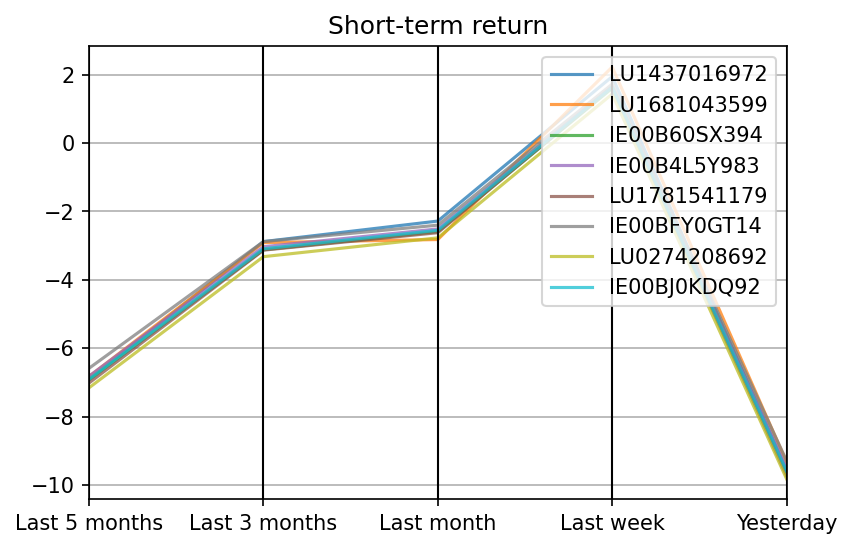

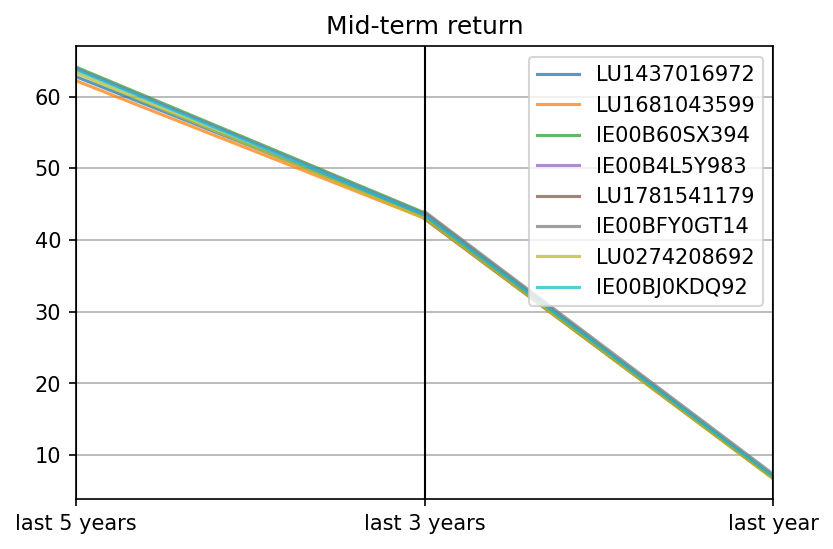

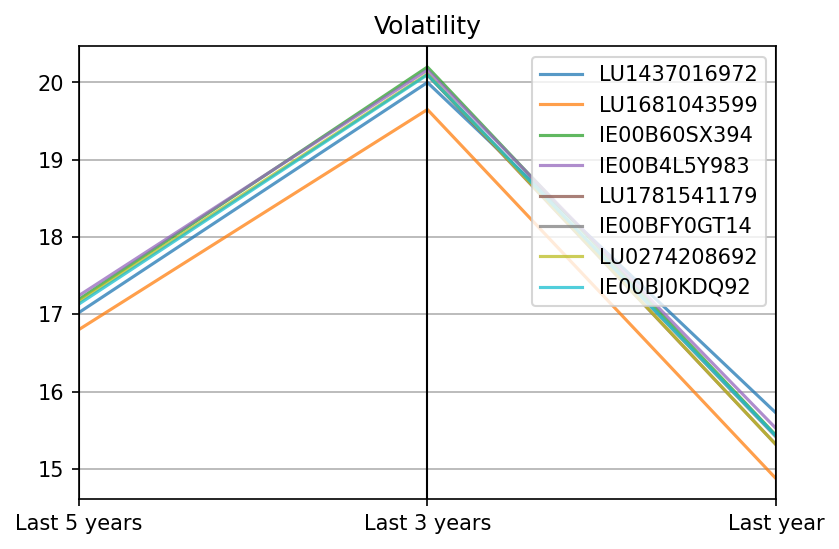

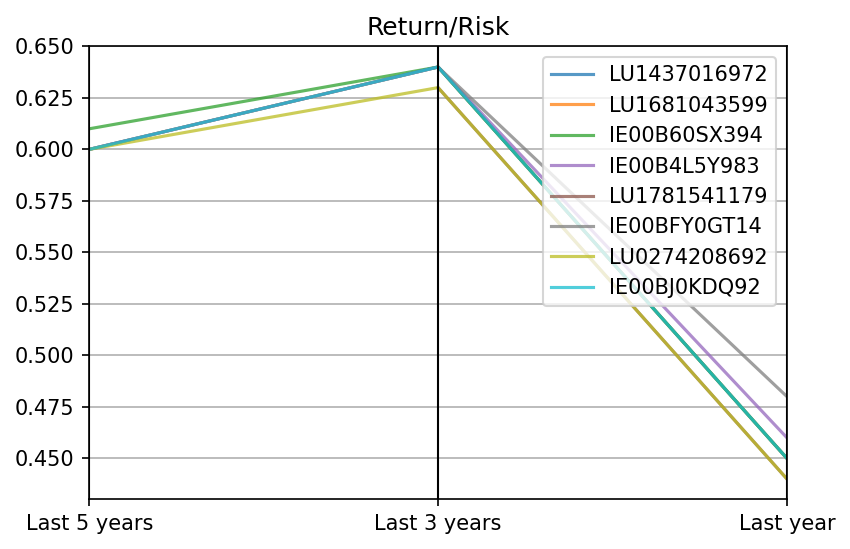

<IPython.core.display.Javascript object>

In [42]:
for title, mapping in COLUMNS_MAPPINGS.items():
    df = acc_msci_world_df[mapping.keys()].rename(columns=mapping)
    plt.figure(dpi=150)
    ax = pd.plotting.parallel_coordinates(df, "isin", colormap="tab10", alpha=0.75)
    _ = ax.set_title(title)

In [43]:
df = acc_msci_world_df[["isin"] + list(reversed(last_four_years))]

<IPython.core.display.Javascript object>

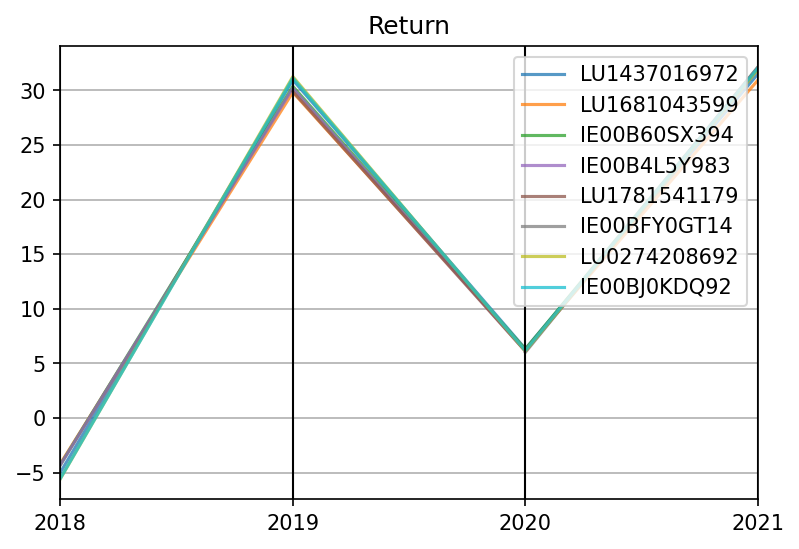

<IPython.core.display.Javascript object>

In [44]:
plt.figure(dpi=150)
ax = pd.plotting.parallel_coordinates(df, "isin", colormap="tab10", alpha=0.75)
_ = ax.set_title("Return")

In [45]:
df = df.set_index("isin")

<IPython.core.display.Javascript object>

In [46]:
ter = (100 - acc_msci_world_df.set_index("isin")["ter"]) / 100

<IPython.core.display.Javascript object>

In [47]:
df = ((100 + df) / 100).mul(ter, axis=0)

<IPython.core.display.Javascript object>

In [48]:
cum_df = df.copy()

<IPython.core.display.Javascript object>

In [49]:
df = (df * 100 - 100).reset_index()

<IPython.core.display.Javascript object>

In [50]:
cum_df[last_four_years[1]] *= cum_df[last_four_years[0]]
cum_df[last_four_years[2]] *= cum_df[last_four_years[1]]
cum_df[last_four_years[3]] *= cum_df[last_four_years[2]]

<IPython.core.display.Javascript object>

In [51]:
cum_df = (cum_df * 100 - 100).reset_index()

<IPython.core.display.Javascript object>

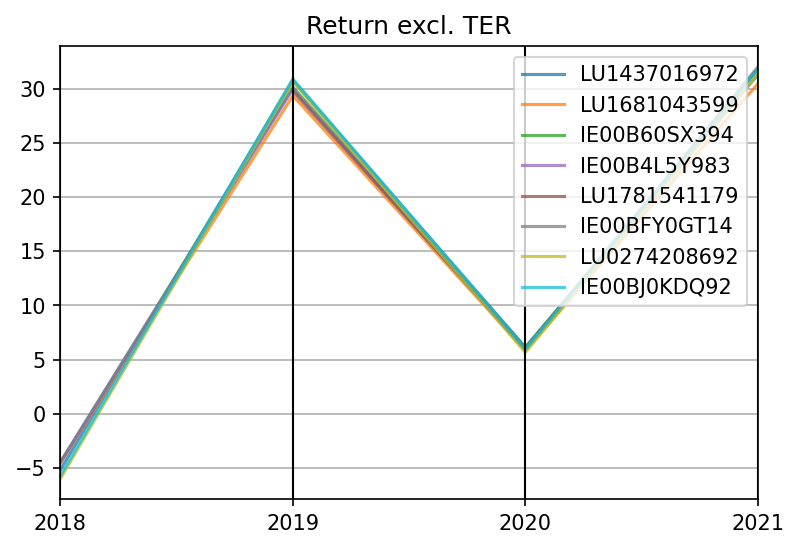

<IPython.core.display.Javascript object>

In [52]:
plt.figure(dpi=150)
ax = pd.plotting.parallel_coordinates(df, "isin", colormap="tab10", alpha=0.75)
_ = ax.set_title("Return excl. TER")

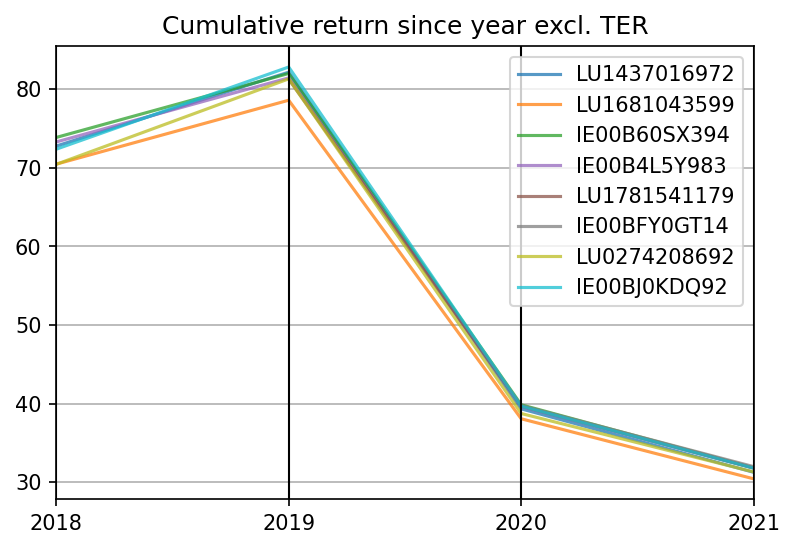

<IPython.core.display.Javascript object>

In [53]:
plt.figure(dpi=150)
ax = pd.plotting.parallel_coordinates(cum_df, "isin", colormap="tab10", alpha=0.75)
_ = ax.set_title("Cumulative return since year excl. TER")